In [31]:
from data_processing import Dataset
from noise import NoiseScheduler
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
import torch


In [32]:
data_dir = "/cephfs/dice/users/ek19824/l1trigger/diffusion/datasets"       ## set to directory where data is stored

dataset = Dataset(1_000, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False)

In [33]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file /cephfs/dice/users/ek19824/l1trigger/diffusion/datasets/CaloImages_signal.root
loading file /cephfs/dice/users/ek19824/l1trigger/diffusion/datasets/CaloImages_signal.root
100%|██████████| 1000/1000 [00:01<00:00, 648.17it/s]
INFO:root:loading file /cephfs/dice/users/ek19824/l1trigger/diffusion/datasets/CaloImages_bkg.root
loading file /cephfs/dice/users/ek19824/l1trigger/diffusion/datasets/CaloImages_bkg.root
100%|██████████| 1000/1000 [00:01<00:00, 665.47it/s]


In [34]:
new_dim=(64,64)

In [35]:
dataset.preprocess(16, new_dim)

INFO:root:scaling
scaling
INFO:root:re-sizing
re-sizing


In [36]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [37]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)

In [49]:
i = 10
noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([10]) #each unit of timestep represents an addtional 5 pile-up events
random_seed = 42
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[i], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)


Text(0.5, 1.0, 'Noised Image')

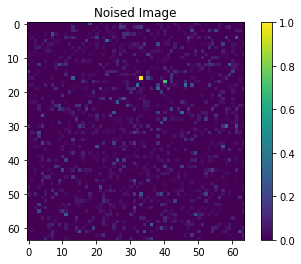

In [50]:

plt.imshow(noisy_image.reshape(new_dim))
plt.colorbar()
plt.title("Noised Image")

In [51]:
from models import Model, UNetLite, UNetLite_hls
modtype = 'UNet_lite'

if modtype == 'UNet2d':
    model = Model('UNet', new_dim)
elif modtype == 'UNet_lite':
    model = UNetLite_hls()

print(model)

UNetLite_hls(
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='nearest')
  (emb1): Linear(in_features=4, out_features=1, bias=True)
  (convd1_1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (normd1_1): GroupNorm(1, 2, eps=1e-05, affine=True)
  (convd1_2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (normd1_2): GroupNorm(1, 4, eps=1e-05, affine=True)
  (emb2): Linear(in_features=4, out_features=4, bias=True)
  (convd2_1): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (normd2_1): GroupNorm(1, 6, eps=1e-05, affine=True)
  (convd2_2): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (normd2_2): GroupNorm(1, 8, eps=1e-05, affine=True)
  (emb3): Linear(in_features=4, out_features=8, bias=True)
  (convd3_1): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [52]:
if modtype == 'UNet2d':
    model = model.__getitem__()

In [53]:
if modtype == 'UNet2d':
    trained_model_path = '/hdfs/user/ys20884/hackathon/trained_models/trained_diffusor.pt'
elif modtype == 'UNet_lite':
    trained_model_path = 'trained_models_lite/model_epoch_9.pt'

print(trained_model_path)

trained_models_lite/model_epoch_9.pt


In [54]:
checkpoint = torch.load(trained_model_path)

In [55]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

Text(0.5, 1.0, 'Noise Prediction')

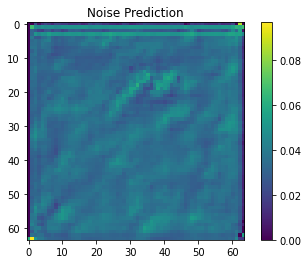

In [56]:
if modtype == 'UNet2d':
    noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0]
elif modtype == 'UNet_lite':
    noise_pred = model(noisy_image.unsqueeze(1), timestep)       #, return_dict=False)[0]

ims = plt.imshow(noise_pred.detach().numpy().reshape(new_dim))
plt.colorbar(ims)
plt.title("Noise Prediction")

In [57]:
de_noised = noisy_image[0] - (noise_pred.detach().numpy().reshape(new_dim))

Text(0.5, 1.0, 'Denoised Image')

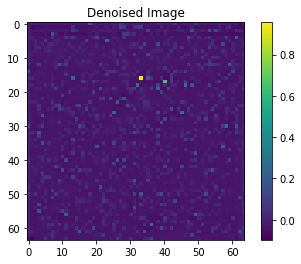

In [58]:

im = plt.imshow(de_noised.reshape(new_dim))
plt.colorbar(im)
plt.title("Denoised Image")

Text(0.5, 1.0, 'Clean Image')

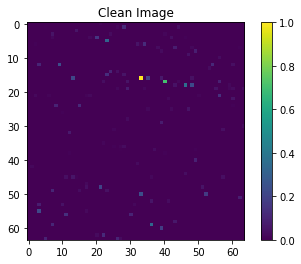

In [59]:
im2 = plt.imshow(clean_frames[i].squeeze())
plt.colorbar(im2)
plt.title("Clean Image")